In [88]:
import pandas as pd
import numpy as np
import os
import pymongo
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.metrics import mean_absolute_error as mae
from sklearn.feature_selection import RFECV
from matplotlib.ticker import MultipleLocator
from matplotlib.backends.backend_pdf import PdfPages
from utils import load_xy, ini_tree, ini_tree_choose, load_config, loc_zq_collection
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression,ElasticNet,Ridge,Lasso
from sklearn.feature_selection import RFE
from tscv import GapWalkForward
import warnings
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']  # 中文显示
plt.rcParams['axes.unicode_minus'] = False  # 负号显示
%matplotlib inline

import matplotlib.ticker as ticker
warnings.filterwarnings("ignore")

import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
X = pd.read_excel('x_sw_coal_features.xlsx', index_col=0)
X.index = [i.strftime("%Y-%m-%d") for i in X.index]
Y = pd.read_excel('y_ppi.xlsx', index_col=0)['PPI:煤炭开采和洗选业:当月同比']
Y.index = [i.strftime("%Y-%m-%d") for i in Y.index]
x_data = X[:85]
y_data = Y[:85]
print('get the x_data and y_data!!!')

get the x_data and y_data!!!


In [3]:
#3折时间序列交叉验证集
tscv = TimeSeriesSplit(n_splits=3,max_train_size=x_data.shape[0]-12)
gcv = GapWalkForward(n_splits=5,gap_size=2,test_size=6)

lre = LinearRegression() #线性回归模型
ela = ElasticNet(alpha = 1) #弹性网络模型
las = Lasso(alpha = 1) # Lasso
rid = Ridge(alpha =1)

22
130
LinearRegression() 

[-0.62634876 -1.71458254 -1.87921595 -1.84125099 -1.21862566 -0.99888436
 -0.501601   -2.54117301 -4.79457411 -4.66459821 -5.72141078 -2.12614225
 -1.54320486 -1.62856149 -1.62725386 -2.48873809 -2.65746948 -3.12306222
 -2.91700356 -2.85201378 -2.81974171 -3.13969547]


12
130
ElasticNet(alpha=0.5) 

[-0.29853154 -2.95419482 -3.16367841 -2.45337672 -1.39580085 -1.38785097
 -1.65908048 -1.6640021  -1.45873627 -1.45041283 -1.43142013 -1.4070741 ]


16
130
Lasso(alpha=0.5) 

[-3.94384082 -4.04311029 -4.86824279 -4.76711665 -4.71002246 -4.55503881
 -4.72515294 -3.55559457 -3.5067122  -2.83651808 -2.83875286 -2.91487897
 -3.07675924 -3.1873299  -2.98147627 -2.78028654]


14
130
Ridge(alpha=0.001) 

[-1.55037221 -1.28051667 -2.21582026 -2.22539905 -3.35787079 -3.62121268
 -3.64417497 -2.18957674 -2.51835689 -1.65510376 -2.97029158 -2.77652108
 -2.74345033 -2.64416775]




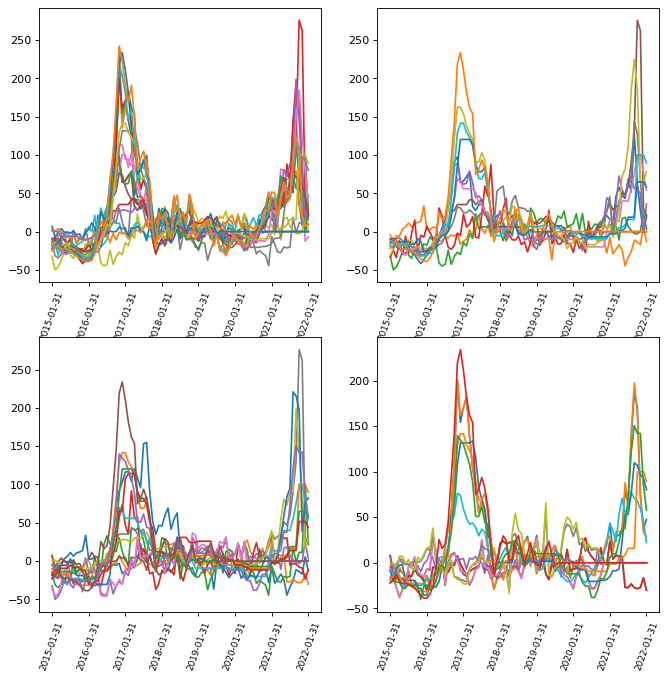

In [66]:
    method = [lre,ela,las,rid]
    k=0
    fig = plt.figure(figsize=(10,10),dpi=80)
    tick_spacing = 12
    for i in method:
        fet = pd.DataFrame()
        rfe = RFECV(estimator=i,step=1,cv=gcv).fit(x_data,y_data)
        k += 1
        sup = rfe.support_
        fet= x_data[x_data.columns[sup]]
#         print(fet)

        # print(rfe.support_)
        # print(rfe.ranking_)
        print(rfe.n_features_)
        print(rfe.n_features_in_)
        # print(rfe.feature_names_in_)
        print(rfe.estimator_,'\n')
        print(rfe.grid_scores_[sup])
        print('\n')
        ax = fig.add_subplot(2,2,k)
        ax.tick_params(axis='x', labelsize=8, rotation=70)
        ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
        ax.plot(fet.index,fet)
        

In [14]:
x_data_ = x_data
for train,test in tscv.split(x_data_):
    # print(x_data.iloc[train],x_data.iloc[test])
    # print(y_data.iloc[train],y_data.iloc[test])
    x_train = x_data_.iloc[train]
    x_test = x_data_.iloc[test]
    y_train = y_data.iloc[train]
    y_test = y_data.iloc[test]
    lre.fit(x_train,y_train)
    ela.fit(x_train,y_train)
    las.fit(x_train,y_train)
    rid.fit(x_train,y_train)
    y_lre = lre.predict(x_test)
    y_ela = ela.predict(x_test)
    y_las = las.predict(x_test)
    y_rid = rid.predict(x_test)
    print(lre.coef_[0:10])
    print(mae(y_test,y_lre))
    print(ela.coef_[0:10])
    print(mae(y_test,y_ela))
    print(las.coef_[0:10])
    print(mae(y_test,y_las))
    print(rid.coef_[0:10])
    print(mae(y_test,y_rid))

[0.00437178 0.00387679 0.00603702 0.00249503 0.00716455 0.00266812
 0.00308872 0.00239913 0.00567354 0.00256158]
21.811856124767917
[0.12448686 0.00403354 0.00904882 0.         0.00013162 0.
 0.         0.         0.         0.        ]
18.851674959643383
[0.11148797 0.         0.01667068 0.         0.00100493 0.
 0.         0.         0.         0.        ]
19.573987838836715
[0.00437178 0.00387679 0.00603701 0.00249505 0.00716453 0.00266813
 0.00308872 0.00239914 0.00567352 0.00256158]
21.811855150384556
[-0.00521991 -0.0067086  -0.01838303  0.00204667  0.00925498 -0.00103452
 -0.00592195 -0.00730156  0.00316212 -0.02024265]
8.718129425367636
[ 0.13515859  0.          0.02118096  0.00085554  0.02079572 -0.00735383
 -0.01089947 -0.01118905  0.05038549 -0.05804021]
10.109096992937761
[ 0.07841395  0.          0.02956922  0.          0.02612892 -0.
 -0.         -0.01016616  0.04698543 -0.05708622]
11.4004203524664
[-0.00522001 -0.00670878 -0.01838257  0.00204659  0.00925476 -0.00103469


C:\Users\GPU_Tjdhf\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.20753456278595062, tolerance: 0.13789386363636363
  model = cd_fast.enet_coordinate_descent(
C:\Users\GPU_Tjdhf\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.34992524197360636, tolerance: 0.13789386363636363
  model = cd_fast.enet_coordinate_descent(
C:\Users\GPU_Tjdhf\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.744252439615211, tolerance: 1.7506024651162793
  model = cd_fast.enet_coordinate_descent(
C:\Users\GPU_Tjdhf\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.

In [6]:
method = [lre,ela,las,rid]
k=0


LinearRegression()
(85, 22)
ElasticNet(alpha=1)
(85, 8)
Lasso(alpha=1)
(85, 26)
Ridge(alpha=1)
(85, 14)
2 3.6388004931121296
[(1, 29.082631068237884), (2, 2.894966419690738), (3, 3.433810588353674), (4, 3.460771633592779), (5, 5.527713509593369), (6, 3.3118446918606903), (7, 2.9031948039770934), (8, 1.919196754728482), (9, 7.412820574027769), (10, 3.978984139655898), (11, 4.394847113248507), (12, 3.004599779651624), (13, 14.464835884654311), (14, 2.6704037061447536), (15, 2.8737428990330467), (16, 8.967913801682577), (17, 11.171312939054673), (18, 10.498737706146219), (19, 21.03002196302322), (20, 46.03147886588134)]


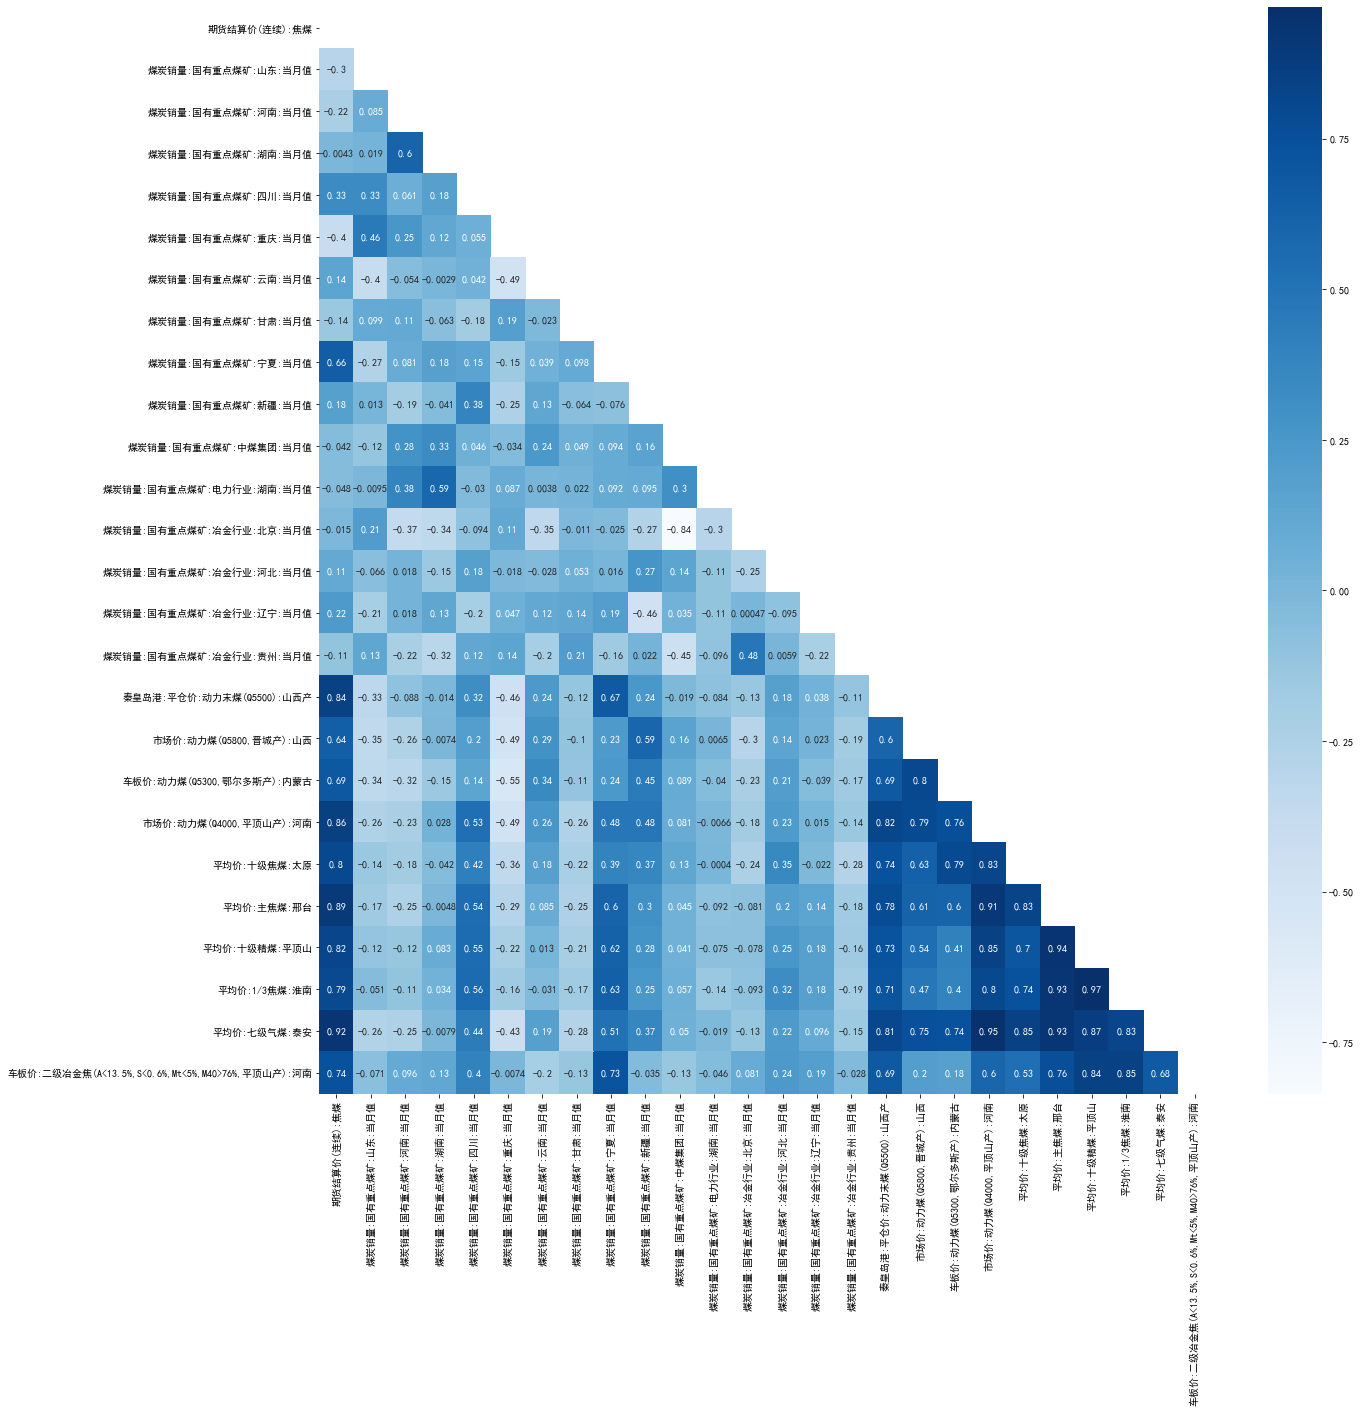

In [22]:
    k=0
    mae2 =[]
    cmm =[[],[],[],[]]
    for i in method:
        rfe = RFECV(estimator=i,step=1,cv=gcv).fit(x_data,y_data)
        k += 1
        sup = rfe.support_
        result = rfe.cv_results_
        col = x_data.columns[sup]

        x_new = x_data[col]
        cmm[k-1] = col
        # print(x_data.columns[sup])
        # print(x_new.head())
        print(rfe.estimator_)
        print(x_data[col].shape)


        mae1 = []
        for train,test in  gcv.split(range(x_new.shape[0])):
            x_train = x_new.iloc[train]
            x_test = x_new.iloc[test]
            y_train = y_data.iloc[train]
            y_test = y_data.iloc[test]

            for j in method:
                j.fit(x_train,y_train)
                y_pred = j.predict(x_test)
                mae1.append(mae(y_test,y_pred))
        mae2.append(np.mean(mae1))

    print(mae2.index(min(mae2)),min(mae2))
    feature = cmm[mae2.index(min(mae2))]
    x_select = x_data[feature]
    cor = x_select.corr()
    fig = plt.figure(figsize=(20,20))
    mask = np.zeros_like(cor)
    mask[np.tril_indices_from(mask)] = True
    sns_plot = sns.heatmap(cor, annot=True,cmap='Blues',mask = mask.T)
    # x_select.to_excel('x_select1.0.xlsx',index=True)
#     print(x_select.shape)
    vif = [variance_inflation_factor(x_select.values, x_select.columns.get_loc(i)) for i in x_select.columns]
    print(list(zip(list(x_select.columns), vif)))

In [32]:
vif_table = pd.DataFrame(vif ,index = x_select.columns)
vif_table.columns = ['VIF']
vif_table

,VIF
期货结算价(连续):焦煤,29.082631
煤炭销量:国有重点煤矿:山东:当月值,2.894966
煤炭销量:国有重点煤矿:河南:当月值,3.433811
煤炭销量:国有重点煤矿:湖南:当月值,3.460772
煤炭销量:国有重点煤矿:四川:当月值,5.527714
煤炭销量:国有重点煤矿:重庆:当月值,3.311845
煤炭销量:国有重点煤矿:云南:当月值,2.903195
煤炭销量:国有重点煤矿:甘肃:当月值,1.919197
煤炭销量:国有重点煤矿:宁夏:当月值,7.412821
煤炭销量:国有重点煤矿:新疆:当月值,3.978984


Del > 100: 
 7.539412907345146
Del > 60: 
 9.68010289386164
Del > 50: 
 9.665766127221303
Del > 40: 
 23.2659263889785
Del > 30: 
 24.58119797584402


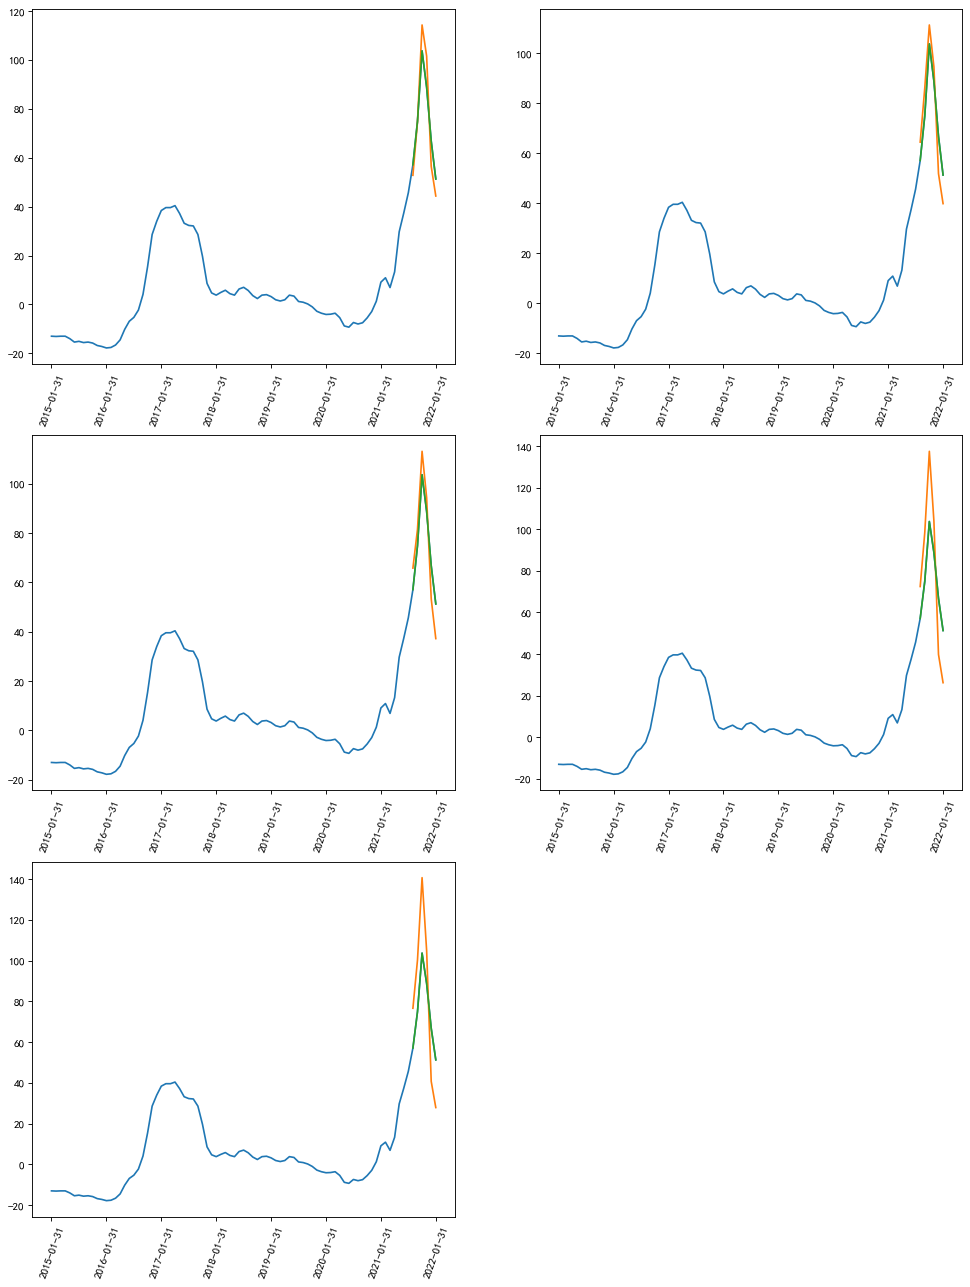

In [86]:
line = [100,60,50,40,30]
fig = plt.figure(figsize=(15,20),dpi=80)
for i in range(len(line)):
    x_vif = x_select[vif_table[vif_table.VIF< line[i]].index]
    las = Lasso(alpha = 1)
    gcv = GapWalkForward(n_splits = 5, gap_size = 2, test_size = 6)
    mae1=[]
    for train,test in  gcv.split(range(x_vif.shape[0])):
        x_train = x_vif.iloc[train]
        x_test = x_vif.iloc[test]
        y_train = y_data.iloc[train]
        y_test = y_data.iloc[test]
        las.fit(x_train,y_train)
        y_pred = las.predict(x_test)
        mae1 = mae(y_test,y_pred)
        
    print('Del > '+str(line[i])+': \n',np.mean(mae1))
    
    tick_spacing = 12
    ax = fig.add_subplot(3,2,i+1)
    ax.tick_params(axis='x', labelsize=10, rotation=70)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    ax.plot(y_data.index,y_data)

    # ax.plot(y_test)
    ax.plot(y_test.index,y_pred)
    ax.plot(y_test.index,y_test)
    